In [1]:

import numpy as np
import gym
from tqdm import trange
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


In [2]:

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      #  number of actions
ns=env.observation_space.shape[0]  #  number of states

N_episodes = 200        # Number of episodes to run for training
discount_factor = 1.    # Value of gamma

# Reward
episode_reward_list = []  # Used to save episodes reward

fourier_order=2 
p = fourier_order + 1
m = pow(p,ns)
alpha=0.001
w=np.zeros([m,k])  
lamba=0.9 
epsilon=0 

In [3]:

def fourierLearningRates(alpha):  
    Ki=np.linalg.norm(eta,axis=1)
    fourierAlpha=alpha/Ki
    fourierAlpha[fourierAlpha==np.inf]=alpha
    fourierAlpha=np.tile(np.array(fourierAlpha), (k, 1)).T
    return fourierAlpha

def fourierFeature(state):
    normstate=scale_state_variables(state)
    return np.cos(np.pi*np.dot(eta,normstate))        

def Qvalue(state,action,w): #compute value of taking some state in some state
    return np.dot(w[:,action],fourierFeature(state))
    
def updateWeights(w,z,fourierAlpha,delta):
    w= w+ delta_t*fourierAlpha*z;
    return w
    
def epsilon_greedy(state,epsilon,w):
    possibleActionValues=np.zeros([k])
    for i in range(k):
        possibleActionValues[i]=Qvalue(state,i,w)
    action=np.argmax(possibleActionValues) 
    if np.random.rand(1)< epsilon:
        action=env.action_space.sample() 
    return action

In [4]:

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x



In [5]:
mesh = np.array(np.meshgrid(np.arange(p), np.arange(p)))
combinations = mesh.T.reshape(-1, 2)
eta = combinations

fourierAlpha=fourierLearningRates(alpha)

In [6]:
eta

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

In [6]:

episode_reward_list=[]
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    EPISODES.set_description('Episode {}'.format(i))
    done = False
    env.reset()
    total_episode_reward = 0.
    state = env.observation_space.sample()
    action=epsilon_greedy(state,epsilon,w)
    z=np.zeros(np.shape(w))  
    while not done:
        z[:,action]=z[:,action]+ fourierFeature(state)
        next_state,reward, done, _ = env.step(action) 
        total_episode_reward += reward
        delta_t = reward - Qvalue(state,action,w);                  
        if done:
            w=updateWeights(w,z,fourierAlpha,delta_t)
            break
        next_action=epsilon_greedy(next_state,epsilon,w)
        delta_t = delta_t + discount_factor*Qvalue(next_state,next_action,w)
        w=updateWeights(w,z,fourierAlpha,delta_t) 
        z=z*discount_factor*lamba            
        state=next_state
        action=next_action
    episode_reward_list.append(total_episode_reward)

Episode 199: 100%|██████████| 200/200 [00:10<00:00, 18.25it/s]


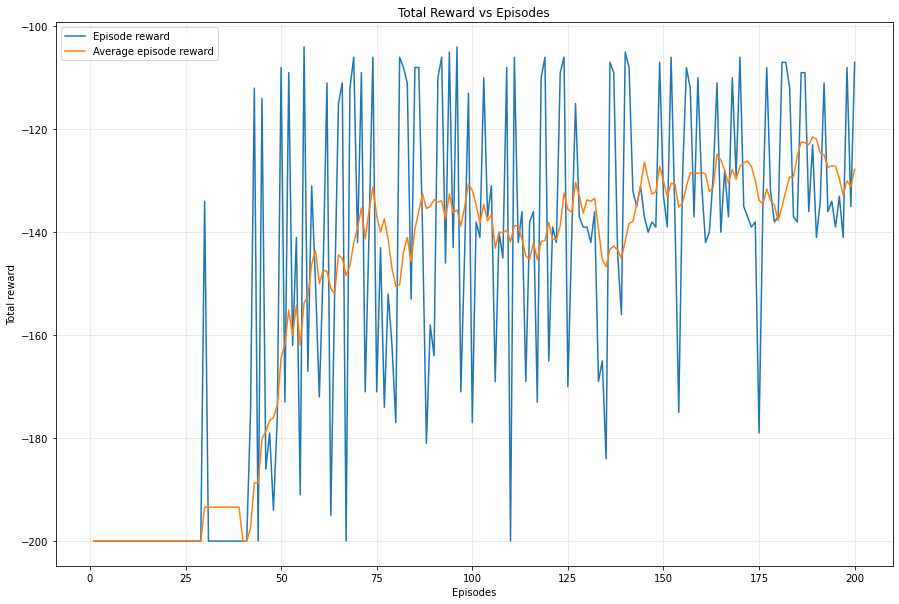

In [10]:
def plotRewards():
    plt.figure(figsize=(15,10))
    plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
    plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
    plt.xlabel('Episodes')
    plt.ylabel('Total reward')
    plt.title('Total Reward vs Episodes')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
plotRewards()

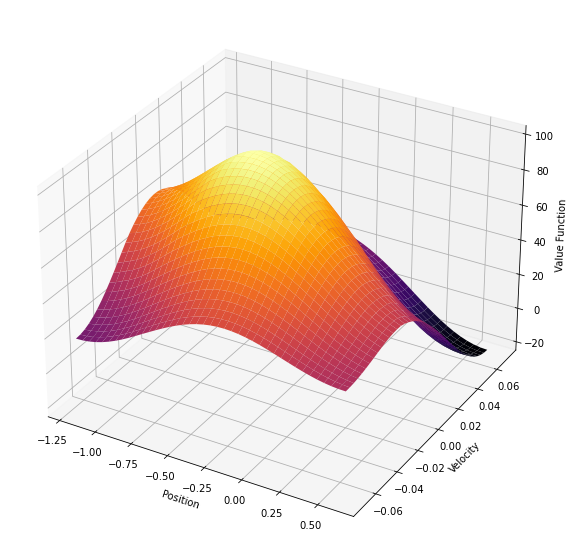

In [8]:
def plotValueFunction():
    meshsize=40
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=meshsize)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=meshsize)
    X, Y = np.meshgrid(x, y)
    plt.figure(figsize=(15,10))
    Z = np.apply_along_axis(lambda s: -np.max([np.dot(w[:,a],fourierFeature(s)) for a in range(k)]), 2, np.dstack([X, Y]))
    ax = plt.axes(projection='3d')
    x = ax.plot_surface(X, Y, Z,cmap='inferno')
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value Function')
    plt.show()
plotValueFunction()

### Saving the dictionary for evaluation

In [9]:
temp=w.T
data={}
data['W']=temp
data['N']=eta
a_file = open("weights.pkl", "wb")
pickle.dump(data, a_file)
a_file.close()
